In [2]:
import warnings
warnings.filterwarnings(action='ignore') # To show code clearly

In [3]:
import os
import csv
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import GEOparse
gse = GEOparse.get_GEO("GSE140345", annotate_gpl='GPL17021', silent=True)

### Pre-processing

In [6]:
sample_info_dict = {}
for gsm_name, gsm in gse.gsms.items():
    if ('RNA' in gsm.metadata['title'][0]) & (int(gsm.metadata['characteristics_ch1'][1].split(': ')[1]) < 74) :
        if len(gsm.metadata['title'][0].split('_')) < 5:
            sample_info_dict[gsm_name] = [gsm.metadata['characteristics_ch1'][2].split(': ')[1], int(gsm.metadata['characteristics_ch1'][1].split(': ')[1])]

sample_info = pd.DataFrame.from_dict(sample_info_dict, orient='index', columns=['condition','time'])

In [7]:
title_to_name = {}
for gsm_name, gsm in gse.gsms.items():
    title_to_name[gsm.metadata['title'][0]] = gsm_name
    
exp_df = pd.read_csv('../data/SD-GSE56931/GSE140345_RNA_level_all_genes.txt', sep='\t|,')
exp_df = exp_df.filter(items=[c for c in exp_df.columns if int(c.split('_')[1][1:]) < 74], axis=1)
exp_df.columns = ['Gene','RNA_T24_NSD_T0N5'] + list(exp_df.columns[2:])
exp_df.rename(columns=title_to_name, inplace=True)
exp_df = exp_df[~exp_df['Gene'].str.contains('Rik')]
exp_df = exp_df.set_index('Gene')
exp_df.index = list(map(str.upper, exp_df.index))
exp_df.loc['PISD',exp_df.columns] = exp_df.loc[['PISD']].sum().values
exp_df = exp_df[~exp_df.index.duplicated(keep='first')]

### DEG search

In [8]:
# ANOVA test
import pingouin as pg

deg_df = exp_df.T
deg_df.insert(0, 'group', ['BS' if gsm in sample_info[sample_info.time < 25].index else 'SR' if gsm in sample_info[sample_info.time < 50].index else '-' for gsm in exp_df.T.index])
deg_df.insert(1, 'time', [str(sample_info.loc[gsm]['time']) for gsm in exp_df.T.index])
deg_df = deg_df[deg_df.group != '-']

DEG_anova = []
for gene in exp_df.index:
    results = pg.anova(dv=gene, between=['group','time'], ss_type=1, data=deg_df[['group','time',gene]])
    reject, corrected_pval = pg.multicomp(results['p-unc'], method='fdr_bh')
    if corrected_pval[0] < 0.05:
        DEG_anova.append(gene)
len(DEG_anova) #3852

3852

In [10]:
# Stationary test (Augemented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

osc_df = pd.DataFrame(columns=deg_df.columns[2:])
for t in [0, 3, 6, 12, 18, 24, 27, 30, 36, 42, 48]:
    osc_df.loc[t] = np.mean(deg_df[deg_df.columns[2:]][deg_df.time==str(t)],axis=0)

nonstationary = []
for gene in osc_df.T.index:
    if adfuller(osc_df.T.loc[gene])[1] >= 0.05 :
        nonstationary.append(gene)
len(nonstationary) #6517

6517

In [41]:
# Oscillation test (Cosinor analysis-24 periodicity)
from CosinorPy import cosinor
import cosinorpy

cosinor_results = pd.DataFrame()
osc_df = osc_df.T
for gene in osc_df.index:
    cosinor_df = pd.DataFrame({'x':osc_df.columns, 'y':osc_df.loc[gene].values, 'test':['test1']*11})
    results = cosinorpy.fit_group(cosinor_df, period=24, plot_on=False)
    results['test'] = gene
    cosinor_results = pd.concat([cosinor_results, results])
oscillation_genes = cosinor_results[cosinor_results.p < 0.05]['test'].values.tolist()
print(len(oscillation_genes)) #871

cosinor_results_BS = pd.DataFrame()
for gene in osc_df.index:
    cosinor_df = pd.DataFrame({'x':osc_df.columns[:6], 'y':osc_df[osc_df.columns[:6]].loc[gene].values, 'test':['test1']*6})
    results = cosinorpy.fit_group(cosinor_df, period=24, plot_on=False)
    results['test'] = gene
    cosinor_results_BS = pd.concat([cosinor_results_BS, results]) 
oscillation_genes_BS = cosinor_results_BS[cosinor_results_BS.p < 0.05]['test'].values.tolist()
len(oscillation_genes_BS) #1191

1154


2650

### Network construction

In [46]:
G = nx.Graph()
DEGs = list(set(DEG_anova).intersection(set(nonstationary)).intersection(set(oscillation_genes_BS)))
print(len(DEGs))
G.add_nodes_from(DEGs) #517

517


In [47]:
# Phase dataframe
for t in set(sample_info.time):
    vars()['T'+str(t)+'_df'] = exp_df[sample_info[sample_info.time == t].index].loc[DEGs]

In [48]:
# Make the edges
from tqdm import tqdm

for t in set(sample_info.time):
    df = vars()['T'+str(t)+'_df']
    edges = []
    for i in tqdm(range(len(df.index))):
        for j in range(len(df.index)):
            if i < j :
                r, p = scipy.stats.pearsonr(df.iloc[i],df.iloc[j])
                if p < 0.05:
                    edges.append((df.index[i], df.index[j], r))
                else: edges.append((df.index[i], df.index[j], 0))
    vars()['T'+str(t)+'_edges'] = edges
    vars()['T'+str(t)+'_filtered_edges'] = [edge for edge in vars()['T'+str(t)+'_edges'] if edge[2] != 0]
    
    vars()['G_T'+str(t)] = G.copy()
    vars()['G_T'+str(t)].add_weighted_edges_from(vars()['T'+str(t)+'_filtered_edges'])    

100%|██████████| 517/517 [00:25<00:00, 20.27it/s]


### Network topology analysis

In [49]:
clustering_coeff = {'BS':[], 'SR':[]}
for t in sorted(set(sample_info.time)):
    if t < 25 : clustering_coeff['BS'].append(np.average(list(nx.clustering(vars()['G_T'+str(t)], weight='weight').values())))
    elif t < 50 : clustering_coeff['SR'].append(np.average(list(nx.clustering(vars()['G_T'+str(t)], weight='weight').values())))

In [50]:
assortativity = {'BS':[], 'SR':[]}
for t in sorted(set(sample_info.time)):
    if t < 25 : assortativity['BS'].append(nx.degree_pearson_correlation_coefficient(vars()['G_T'+str(t)], weight='weight'))
    elif t < 50 :assortativity['SR'].append(nx.degree_pearson_correlation_coefficient(vars()['G_T'+str(t)], weight='weight'))

In [51]:
from __future__ import division

def centrality_distribution(G):
    centrality = nx.eigenvector_centrality_numpy(G, weight='weight').values()
    centrality = list(centrality)
    centrality = np.array(centrality) / sum(centrality)
    return centrality

def graph_entropy(dist):
    dist = np.asarray(dist)
    ent = np.nansum( dist *  np.log2( 1/dist ) )
    return ent

entropy = {'BS':[],'SR':[]}
for t in sorted(set(sample_info.time)):
    d = centrality_distribution(vars()['G_T'+str(t)])
    if t < 25 : entropy['BS'].append(graph_entropy(d))
    elif t < 50 : entropy['SR'].append(graph_entropy(d))

In [52]:
modularity = {'BS':[], 'SR':[]}
for t in sorted(set(sample_info.time)):
    if t < 25 : modularity['BS'].append(nx.community.modularity(vars()['G_T'+str(t)], nx.community.label_propagation_communities(vars()['G_T'+str(t)])))
    elif t < 50 : modularity['SR'].append(nx.community.modularity(vars()['G_T'+str(t)], nx.community.label_propagation_communities(vars()['G_T'+str(t)])))

### Sleep homeostasis - Circadian effects

In [64]:
# Linear mixed-effects model

import math
from scipy.optimize import curve_fit

def fillna(data, col=[i+1 for i in range(12)]):
    df = pd.DataFrame(data, columns=col)
    df = df.T.interpolate()
    df = df.fillna(method='ffill') #fillna with previous time value
    df = df.fillna(method='bfill') #fillna with next time value
    return df.T

def func(x, a, b, c, d, e):
    return a + b*np.log(x) + c*np.cos(2*math.pi*(x+d)/24) + e

def exponential_func(x, a, b, c):
    return a - b*np.log2(c*x)

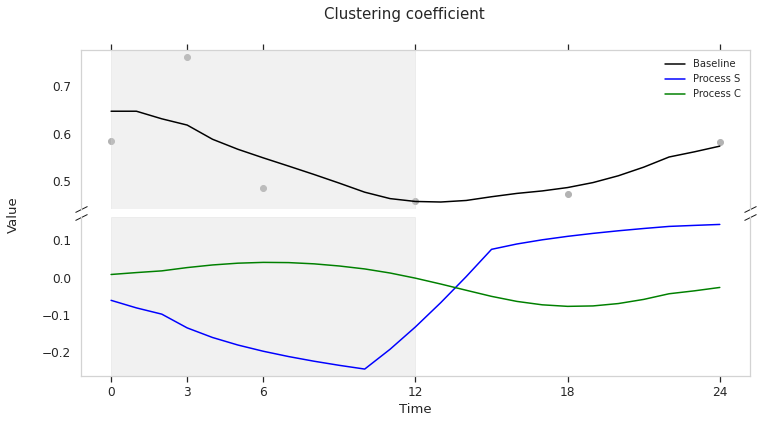

In [65]:
# Dynamics in Clustering coefficient for normal sleep mouse

def func(x, a, b, c, e):
    d = 2 * math.pi
    return a + b*np.log(x) + c*np.cos(2*math.pi*(x-d)/24) + e

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
xdata = np.arange(1,13)
df_night = pd.DataFrame(clustering_coeff['BS'][:4]).T #3,6,12
df_day = pd.DataFrame(clustering_coeff['BS'][3:]).T #12,18,24
df_night.columns = [1,3,6,11]; df_day.columns = [1,6,11]
popt_night, pcov_night = curve_fit(func, xdata, fillna(df_night).values[0], absolute_sigma=True)
popt_day, pcov_day = curve_fit(func, xdata, fillna(df_day).values[0], absolute_sigma=True)
popt_S_night, pcov_S_night = curve_fit(exponential_func, xdata, fillna(df_night).values[0])
popt_S_day, pcov_S_day = curve_fit(exponential_func, xdata, fillna(df_day).values[0])

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0.05)
ax1.scatter([0,3,6,12,18,24], np.concatenate([df_night.values[0], df_day.values[0][1:]]), color=sns.color_palette('Set2')[-1])
estimated_values = np.concatenate([func(np.arange(1,13),popt_night[0],popt_night[1],popt_night[2],popt_night[3]), func(np.arange(1,13),popt_day[0],popt_day[1],popt_day[2],popt_day[3])])
smoothed_values = pd.Series(estimated_values).rolling(window=5, min_periods=1, center=True).mean()
smoothed_values.fillna(method='bfill', inplace=True)  
smoothed_values.fillna(method='ffill', inplace=True)
smoothed_values = np.concatenate([[smoothed_values[0]],smoothed_values])
ax1.plot(np.arange(0,25), smoothed_values, color='black', label='Baseline')
ax1.axvspan(0, 12, color='lightgray', alpha=0.3)

estimated_S = np.concatenate([popt_night[1]*np.log(np.arange(0,13)+1), popt_day[1]*np.log(np.arange(1,13)+1)])
estimated_C = np.concatenate([popt_night[2]*np.cos(2*math.pi*(np.arange(0,13)-2*math.pi)/24), popt_day[2]*np.cos(2*math.pi*(np.arange(1,13)-2*math.pi)/24)])
smoothed_S = pd.Series(estimated_S).rolling(window=5, min_periods=1, center=True).mean()
smoothed_C = pd.Series(estimated_C).rolling(window=5, min_periods=1, center=True).mean()
smoothed_S.fillna(method='bfill', inplace=True); smoothed_S.fillna(method='ffill', inplace=True)
smoothed_C.fillna(method='bfill', inplace=True); smoothed_C.fillna(method='ffill', inplace=True)
ax2.plot(np.arange(0,25), smoothed_S, color='blue', label='Process S') #homeostasis
ax2.plot(np.arange(0,25), smoothed_C, color='green', label='Process C') #circadian
ax2.axvspan(0, 12, color='lightgray', alpha=0.3)

ax1.spines['bottom'].set_visible(False); ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top(); ax2.xaxis.tick_bottom()
ax1.tick_params(labeltop=False)
kwargs = dict(marker=[(-1,-0.5),(1,0.5)], markersize=12, linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0,1],[0,0], transform=ax1.transAxes, **kwargs)
ax2.plot([0,1],[1,1], transform=ax2.transAxes, **kwargs)

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize=10, frameon=False)
plt.xlabel('Time'); fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')
plt.xticks([0,3,6,12,18,24])
fig.suptitle("Clustering coefficient", fontsize=15)
plt.show()

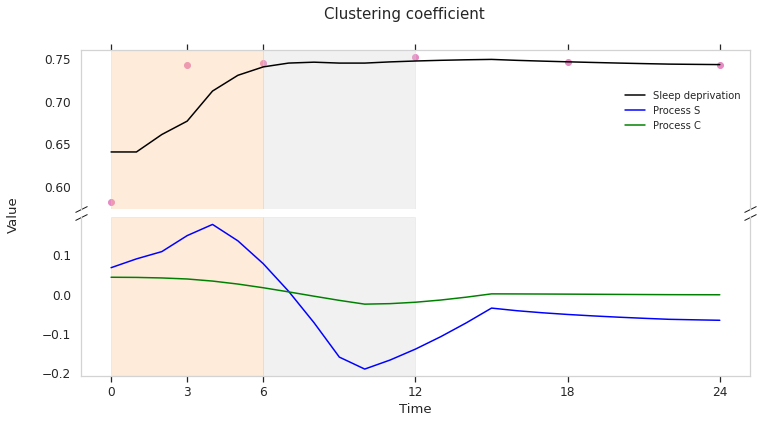

In [66]:
# Dynamics in Clustering coefficient for sleep deprivation mouse

def func(x, a, b, c, e):
    d = 1/2 * math.pi
    return a + b*np.log(x) + c*np.cos(2*math.pi*(x-d)/24) + e

sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
xdata = np.arange(1,13)
df_night = pd.DataFrame(np.concatenate([clustering_coeff['BS'][-1:],clustering_coeff['SR'][:2]])).T #24,27,30
df_middle = pd.DataFrame(clustering_coeff['SR'][1:3]).T #30,36
df_day = pd.DataFrame(clustering_coeff['SR'][2:]).T #36,42,48
df_night.columns = [1,4,7]; df_day.columns = [1,6,11]; df_middle.columns = [1,7]
popt_night, pcov_night = curve_fit(func, np.arange(1,7), fillna(df_night, col=[i+1 for i in range(6)]).values[0], absolute_sigma=True)
popt_day, pcov_day = curve_fit(func, xdata, fillna(df_day).values[0], absolute_sigma=True)
popt_middle, pcov_middle = curve_fit(func, np.arange(1,7), fillna(df_middle, col=[i+1 for i in range(6)]).values[0], absolute_sigma=True)
popt_S_night, pcov_S_night = curve_fit(exponential_func, xdata, np.concatenate([fillna(df_night, col=[i+1 for i in range(6)]).values[0], fillna(df_middle, col=[i+1 for i in range(6)]).values[0]]))
popt_S_day, pcov_S_day = curve_fit(exponential_func, xdata, fillna(df_day).values[0])

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.subplots_adjust(hspace=0.05)
ax1.scatter([0,3,6,12,18,24], np.concatenate([df_night.values[0], df_day.values[0]]), color=sns.color_palette('Set2')[3])
estimated_values = np.concatenate([func(np.arange(1,7),popt_night[0],popt_night[1],popt_night[2],popt_night[3]), func(np.arange(1,7),popt_middle[0],popt_middle[1],popt_middle[2],popt_middle[3]), func(np.arange(1,13),popt_day[0],popt_day[1],popt_day[2],popt_day[3])])
smoothed_values = pd.Series(estimated_values).rolling(window=5, min_periods=1, center=True).mean()
smoothed_values.fillna(method='bfill', inplace=True)  
smoothed_values.fillna(method='ffill', inplace=True)
smoothed_values = np.concatenate([[smoothed_values[0]], smoothed_values])
ax1.plot(np.arange(0,25), smoothed_values, color='black', label='Sleep deprivation')
ax1.axvspan(0, 6, color=sns.color_palette('Accent')[2], alpha=0.3)
ax1.axvspan(6, 12, color='lightgray', alpha=0.3)

estimated_S = np.concatenate([popt_night[1]*np.log(np.arange(0,7)+1), popt_middle[1]*np.log(np.arange(1,7)+1)*10**8, popt_day[1]*np.log(np.arange(1,13)+1)*10])
estimated_C = np.concatenate([popt_night[2]*np.cos(2*math.pi*(np.arange(0,13)-1/2*math.pi)/24), popt_day[2]*np.cos(2*math.pi*(np.arange(1,13)-1/2*math.pi)/24)])
smoothed_S = pd.Series(estimated_S).rolling(window=5, min_periods=1, center=True).mean()
smoothed_C = pd.Series(estimated_C).rolling(window=5, min_periods=1, center=True).mean()
smoothed_S.fillna(method='bfill', inplace=True); smoothed_S.fillna(method='ffill', inplace=True)
smoothed_C.fillna(method='bfill', inplace=True); smoothed_C.fillna(method='ffill', inplace=True)
ax2.plot(np.arange(0,25), smoothed_S, color='blue', label='Process S') #homeostasis
ax2.plot(np.arange(0,25), smoothed_C, color='green', label='Process C') #circadian
ax2.axvspan(0, 6, color=sns.color_palette('Accent')[2], alpha=0.3)
ax2.axvspan(6, 12, color='lightgray', alpha=0.3)

ax1.spines['bottom'].set_visible(False); ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top(); ax2.xaxis.tick_bottom()
ax1.tick_params(labeltop=False)
kwargs = dict(marker=[(-1,-0.5),(1,0.5)], markersize=12, linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0,1],[0,0], transform=ax1.transAxes, **kwargs)
ax2.plot([0,1],[1,1], transform=ax2.transAxes, **kwargs)

fig.legend(loc='upper left', bbox_to_anchor=(0.8, 0.8), bbox_transform=ax1.transAxes, fontsize=10, frameon=False)
plt.xlabel('Time'); fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')
plt.xticks([0,3,6,12,18,24])
fig.suptitle("Clustering coefficient", fontsize=15)
plt.show()